# Prev

## include

In [1]:
include("../../src/struct_data.jl")
include("../../src/neighbor.jl")
include("../../src/forces/forces.jl")
include("../../src/run_event.jl")

RunFusionAggregates (generic function with 1 method)

## model

In [2]:
@time model = ModelSet(
    TimeModel(
        tₛᵢₘ  = 150000.0,
        dt    = 0.5,
        nₖₙₙ  = 100,
        nₛₐᵥₑ = 50
    ),
    InputModel(
        outer_ratio = 0.8,
        path_input  = "../../data/init/Sphere"
    ),
    OutputModel(
        name_output = "Test_1",
        path_output = "",
        d_saved = 0.5
    ) 
)

  0.000009 seconds (5 allocations: 208 bytes)


ModelSet(TimeModel(150000.0, 0.5, 100, 50), InputModel(0.8, "../../data/init/Sphere"), OutputModel("Test_1", "", 0.5))

# Run

## Some Founded Parameters

### Cubic

In [3]:
# # Complete (Oriola Contractile Model) -> Normal Vectors of distance between cells without area
# Par1, Par2 = Cubic(0.0055,2.0,4.5), ContractilePar(0.162);
# Par1, Par2 = Cubic(0.0055,2.0,4.5), ContractilePar(0.166);
# Par1, Par2 = Cubic(0.0055,2.0,4.5), ContractilePar(0.164);

## Fusion Agg

In [4]:
# Run Model
Par1 ,Par2 = Cubic(0.05,2.0,3.0), ContractilePar(0.25)
# ContractilePar(0.02);
# RunFusionAggregates(model::ModelSet, Par1, Par2, 15)
size_agg = 15

15

In [5]:
# Run only one aggregate
agg = nothing
agg = Aggregate(
    [AggType(
        "HEK_1", 
        InteractionPar(Par1, Par2),
        Float32.(readdlm("../../data/init/Sphere/$(size_agg).0.xyz")[3:end,2:end]) |> cu
    )], 
    [AggLocation("HEK_1",[0 0 0]),],
    model
)

Aggregate(AggType[AggType("HEK_1", InteractionPar(Cubic{Float64}(0.05, 2.0, 3.0), ContractilePar(0.25)), 15.27f0, Float32[-1.5 -4.62 -13.88; 0.5 -4.62 -13.88; … ; 0.5 4.62 13.88; 2.5 4.62 13.88], CuArray{Float32, 2, CUDA.Mem.DeviceBuffer})], AggIndex([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], ["HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1"  …  "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1", "HEK_1"]), Float32[-1.5 -4.62 -13.88; 0.5 -4.62 -13.88; … ; 0.5 4.62 13.88; 2.5 4.62 13.88], AggGeometry(Float32[15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27  …  15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27, 15.27], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (-14.5f0, 14.5f0)), AggSimulation(AggParameter(Cubic{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}}(Float32[0.05, 0.05, 0.05,

In [6]:
run_test(agg, model,"Run One Aggregate", false, false)

Run One Aggregate... 100%|███████████████████████████████| Time: 0:03:0839m


In [7]:
position=agg.Position
open("init_stable.xyz", "a") do f
    write(f, "Initial Stable\n")
    write(f, "t=0\n")
    writedlm(f,hcat(agg.Geometry.outline,Matrix(position)), ' ')
end

# Run fusion of two aggregates
agg = nothing
agg = FusionAggregate(
    [AggType("HEK_1", InteractionPar(Par1, Par2),position)], 
    model
)
run_test(agg, model, "Fusion of Two Aggregates", true, true)

# display(sum(isnan.(agg.Simulation.Force.F), dims=1))
# display(sum(agg.Simulation.Force.F .> 50, dims=1))
# display(agg.Simulation.Force.F)
# display(agg.Position)

Fusion of Two Aggregates... 100%|████████████████████████| Time: 0:06:16:45


Animating ... 100%|██████████████████████████████████████| Time: 0:00:01
[ Info: Saved animation to /home/nicomosty/Documentos/MaestriaUNAL/CellAggregate.jl/test/KernelCUDA/tmp.gif


Plots.AnimatedGif("/home/nicomosty/Documentos/MaestriaUNAL/CellAggregate.jl/test/KernelCUDA/tmp.gif")
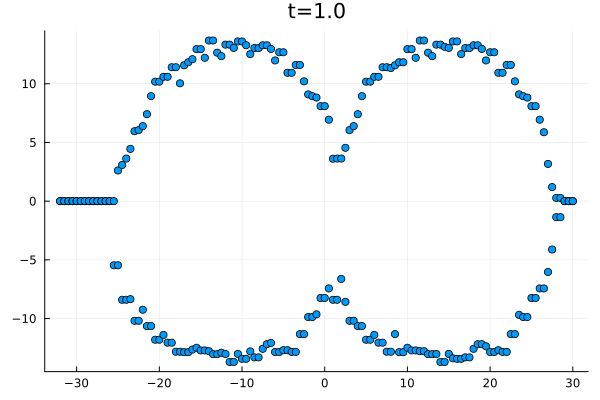

In [54]:
test = hcat([hcat([agg.Simulation.Output.x_axis,agg.Simulation.Output.outline_data[i,:]]...) for i=1:size(agg.Simulation.Output.outline_data,1)]...)

using Plots
p = Progress(convert(Int,size(test,2)/2-2),"Animating ...")
anim = @animate for t = 1:2:2*(size(data,2)-1)
    plot(
        test[:,t], 
        test[:,t+1],
        title = "t=$((t+1)/2)",
        seriestype=:scatter,
        legend = false
    )
    next!(p)
end

gif(anim, fps=2)

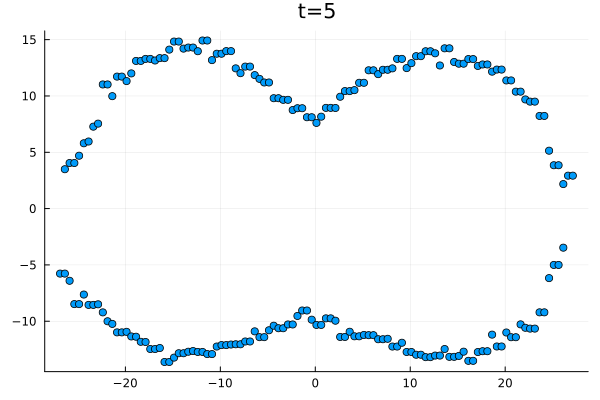

In [141]:
i = 5
Q = test[:,i:i+1][test[:,i+1] .!= 0,:] .- sum(test[:,i:i+1][test[:,i+1] .!= 0,:],dims=1)/size(test[:,i:i+1][test[:,i+1] .!= 0,:],1) 

plot(
    Q[:,1], 
    Q[:,2],
    title = "t=$(i)",
    seriestype=:scatter,
    legend = false
)
# using Plots
# p = Progress(convert(Int,size(tropo,2)/2-2),"Animating ...")
# anim = @animate for t = 1:2:2*(size(data,2)-1)
#     plot(
#         tropo[:,t], 
#         tropo[:,t+1],
#         title = "t=$((t+1)/2)",
#         seriestype=:scatter,
#         legend = false
#     )
#     next!(p)
# end

# gif(anim, fps=2)